In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
from PIL import Image
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

In [2]:
SIZE = 256

np.random.seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [3]:
# Smear
image_directory = 'data/'
train_images = []
train_labels = [] 

parasitized_images = os.listdir(image_directory + 'malaria/')
# Go thru every image and resize + add label.
for i, image_name in enumerate(parasitized_images):

    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'malaria/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        train_images.append(np.array(image))
        train_labels.append(1)
        
uninfected_images = os.listdir(image_directory + 'no_malaria/')
for i, image_name in enumerate(uninfected_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'no_malaria/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        train_images.append(np.array(image))
        train_labels.append(0)


In [4]:
activation = 'relu'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', input_shape = (SIZE, SIZE, 3)))
feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(128, 3, activation = activation, padding = 'same'))
feature_extractor.add(Conv2D(128, 3, activation = activation, padding = 'same'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(256, 3, activation = activation, padding = 'same'))
feature_extractor.add(Conv2D(256, 3, activation = activation, padding = 'same'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(512, 3, activation = activation, padding = 'same'))
feature_extractor.add(Conv2D(512, 3, activation = activation, padding = 'same'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(1024, 3, activation = activation, padding = 'same'))
feature_extractor.add(Conv2D(1024, 3, activation = activation, padding = 'same'))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Flatten())

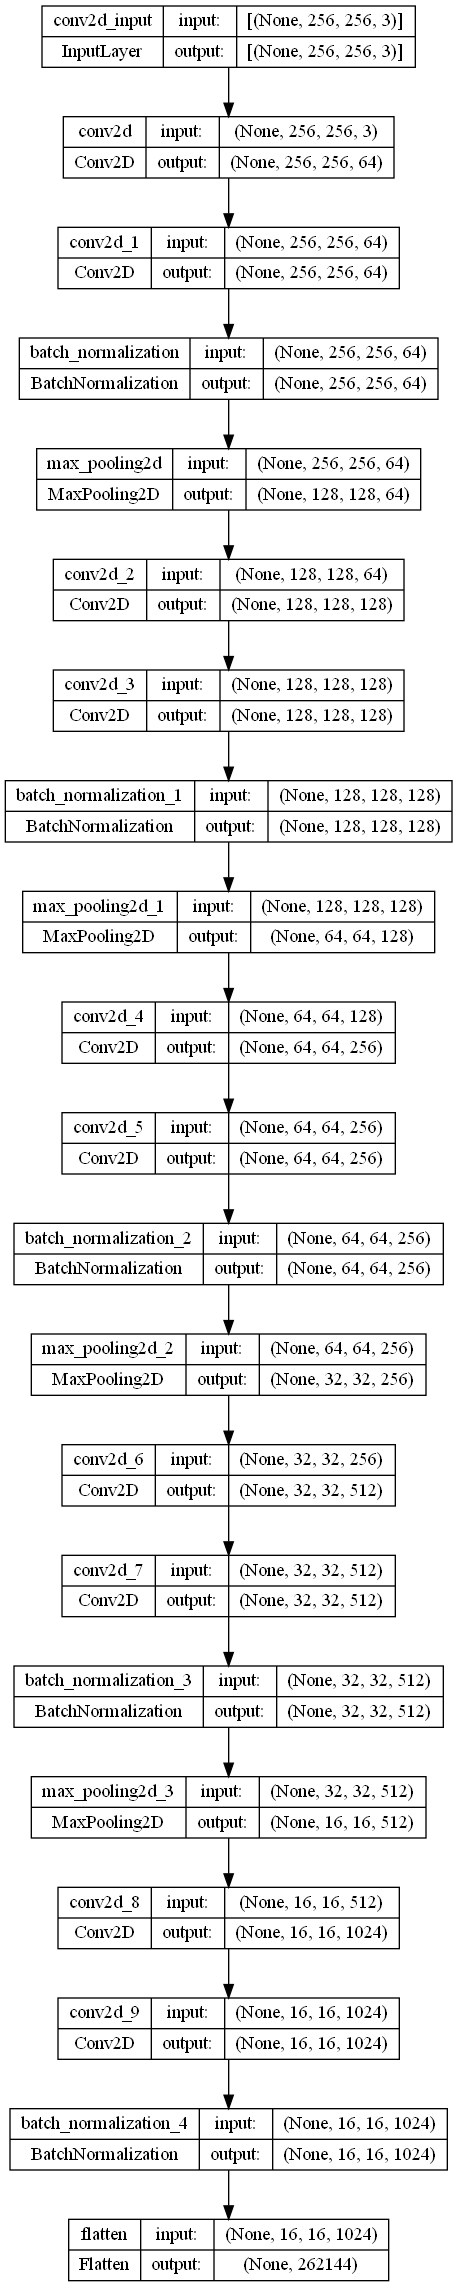

In [6]:
from keras.utils.vis_utils import plot_model
plot_model(feature_extractor, to_file='custom_extractor_plot.png', show_shapes=True)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(train_images, np.array(train_labels),
                                                    test_size=0.20, random_state=0)

In [50]:
X_train = np.array(X_train)
X_for_classify = feature_extractor.predict(X_train) 

5/5 [==============================] - 16s 3s/step


In [51]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

RF_model.fit(X_for_classify, y_train)

#Send test data through same feature extractor process
X_test = np.array(X_test)

start_RF = time.perf_counter()
X_test_feature = feature_extractor.predict(X_test)

#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_feature)
#Inverse le transform to get original label back. 
runtimes_RF = time.perf_counter() - start_RF

# Evaluate metric
print ("Accuracy: {:.2f}%".format(metrics.accuracy_score(y_test, prediction_RF)*100))
print("F1: {:.2f}".format(metrics.f1_score(y_test,prediction_RF)))
print("AuC: {:.2f}".format(metrics.roc_auc_score(y_test, prediction_RF)))
print("Precision : {:.2f}%".format(metrics.precision_score(y_test, prediction_RF)*100))
print("Recall : {:.2f}%".format(metrics.recall_score(np.array(y_test), prediction_RF)*100))
print("Run time: {:.2f}s ".format(runtimes_RF))

2/2 [==============================] - 5s 1s/step
Accuracy: 65.00%
F1: 0.61
AuC: 0.65
Precision : 61.11%
Recall : 61.11%
Run time: 5.03s 


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

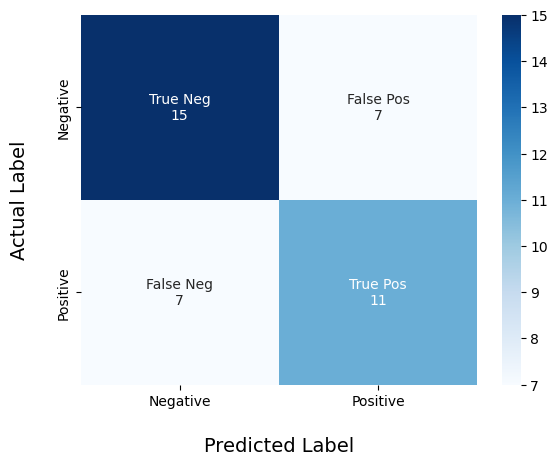

In [52]:
# Confusion matrix RF
cm = confusion_matrix(y_test, prediction_RF)


group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels,fmt='', cmap='Blues')
ax.set_xlabel("Predicted Label", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_ylabel("Actual Label", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

In [53]:
# SVM
from sklearn import svm
svm_model = svm.SVC(probability=True)

svm_model.fit(X_for_classify,y_train)

X_test = np.array(X_test)

start_SVM = time.perf_counter()
X_test_feature = feature_extractor.predict(X_test)
prediction_SVM = svm_model.predict(X_test_feature)
runtimes_SVM = time.perf_counter() - start_SVM

# Evaluate metric
print ("Accuracy: {:.2f}%".format(metrics.accuracy_score(y_test, prediction_SVM)*100))
print("F1: {:.2f}".format(metrics.f1_score(y_test,prediction_SVM)))
print("AuC: {:.2f}".format(metrics.roc_auc_score(y_test, prediction_SVM)))
print("Precision : {:.2f}%".format(metrics.precision_score(y_test, prediction_SVM)*100))
print("Recall : {:.2f}%".format(metrics.recall_score(np.array(y_test), prediction_SVM)*100))
print("Run time: {:.2f}s ".format(runtimes_SVM))

2/2 [==============================] - 4s 932ms/step
Accuracy: 45.00%
F1: 0.62
AuC: 0.50
Precision : 45.00%
Recall : 100.00%
Run time: 11.87s 


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

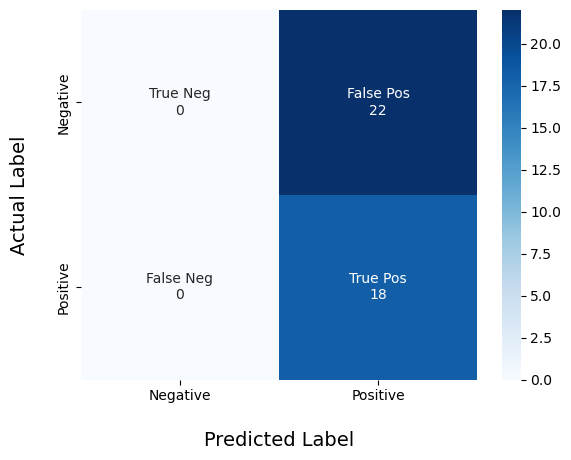

In [37]:
# Confusin matrix SVM
cm = confusion_matrix(y_test, prediction_SVM)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels,fmt='', cmap='Blues')
ax.set_xlabel("Predicted Label", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_ylabel("Actual Label", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Negative', 'Positive'])